# NASA Turbofan Predictive Maintenance

This notebook aims to predict the remaining useful life (RUL) of engines using operational & sensor reading data, provided by NASA via Kaggle. 

It will start by exploring the data using statistics and visualisations, before moving onto modelling the data. The aim o the Kaggle conmpetition is simply to predict if an engine has failed or not (i.e. RUL is 0). However, there are numerous ways in which this can be achieved. A range of models have been employed in this analysis.

The data will be modelled in 2 main ways:

**1. Regression:**

This will aim to predict a continuous value for RUL. Models will be assessed on their ability to closely match the RUL of engines.

**2. Classification:**

For this, the data will have to be classified using the RUL feature. if the RUL is above 0, then the engines are still active (data labelled 0), otherwise, the engine has failed (data labelled 1). Due to the large disparity in class size, accuracy metrics are initially expected to be poor.

## Improvement Points

* Perform wider range of EDA to further understand data.
* Make engine no. a categoricalk feature in models.
* Test wider range of scalers.
* Test Lambda and Ridge Regression models to try and utilise feature coefficient minimisation.
* Tune hyperparemters on Random Forest model.
* Time series feature engineering (Rolling values, fourier series transformations).
* Try to even class sizes for classification (upsampling, SMOTE etc).
* Classify engine as 'Failed' or not based on results of regression models.

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

### Load Data

In [4]:
train_df = pd.read_csv('train_data.csv')
assess_df = pd.read_csv('test_data.csv') 

## EDA

In [5]:
train_df.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,...,84.93,14.35,8.4712,NaN,NaN,NaN,NaN,NaN,NaN,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,...,100.00,14.88,8.9928,NaN,NaN,NaN,NaN,NaN,NaN,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,...,84.93,14.21,8.5107,NaN,NaN,NaN,NaN,NaN,NaN,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,...,100.00,10.63,6.4578,NaN,NaN,NaN,NaN,NaN,NaN,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,...,100.00,14.95,9.0279,NaN,NaN,NaN,NaN,NaN,NaN,335


In [6]:
train_df.shape

(160359, 33)

In [7]:
train_df['engine_no'].nunique()

709

In [8]:
train_df[train_df.RUL == 0]['RUL'].count()

709

In [9]:
train_df.isna().sum()

engine_no              0
time_in_cycles         0
op_setting_1           0
op_setting_2           0
op_setting_3           0
sensor_1               0
sensor_2               0
sensor_3               0
sensor_4               0
sensor_5               0
sensor_6               0
sensor_7               0
sensor_8               0
sensor_9               0
sensor_10              0
sensor_11              0
sensor_12              0
sensor_13              0
sensor_14              0
sensor_15              0
sensor_16              0
sensor_17              0
sensor_18              0
sensor_19              0
sensor_20              0
sensor_21              0
sensor_22         160359
sensor_23         160359
sensor_24         160359
sensor_25         160359
sensor_26         160359
sensor_27         160359
RUL                    0
dtype: int64

Sensors 22-27 have no data so drop

In [10]:
train_df.drop(['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27'], inplace = True, axis = 1)

Check columns of data to assess

In [11]:
assess_df.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27
0,0,1,42.0034,0.8400,100.0,445.00,549.36,1342.05,1124.56,3.91,...,2212,100.0,10.69,6.3956,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,42.0017,0.8400,100.0,445.00,548.83,1351.93,1116.28,3.91,...,2212,100.0,10.55,6.3775,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,0.0028,0.0019,100.0,518.67,642.35,1583.74,1400.44,14.62,...,2388,100.0,38.85,23.3483,NaN,NaN,NaN,NaN,NaN,NaN
3,0,4,42.0047,0.8400,100.0,445.00,549.69,1354.36,1125.55,3.91,...,2212,100.0,10.56,6.4871,NaN,NaN,NaN,NaN,NaN,NaN
4,0,5,10.0058,0.2506,100.0,489.05,604.72,1496.65,1310.52,10.52,...,2319,100.0,28.78,17.1987,NaN,NaN,NaN,NaN,NaN,NaN


Generate correlations

In [12]:
corrs = train_df.corr()

Look at Distributions

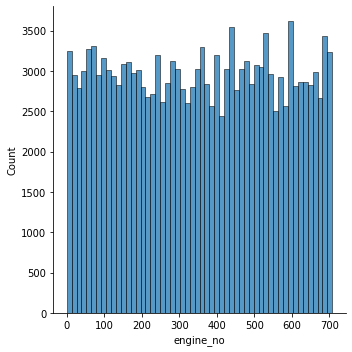

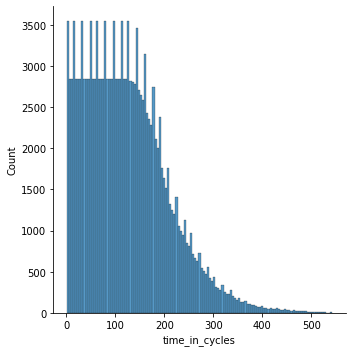

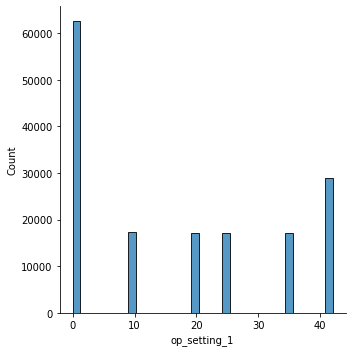

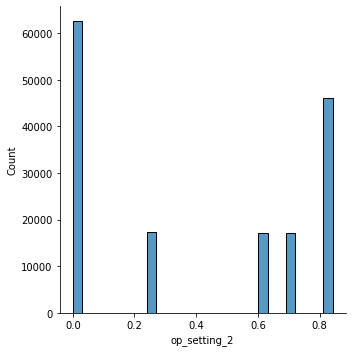

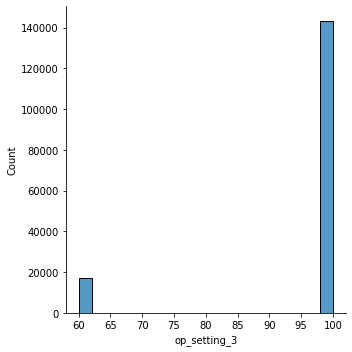

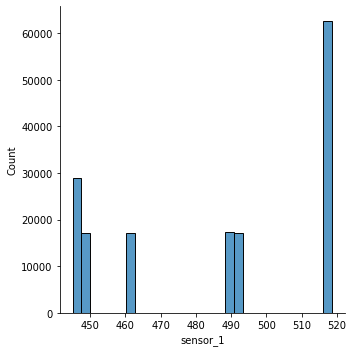

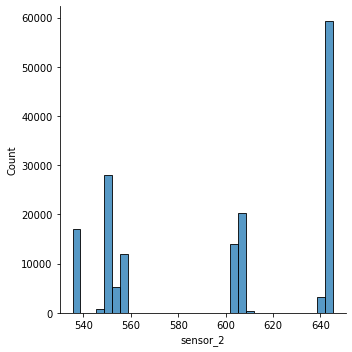

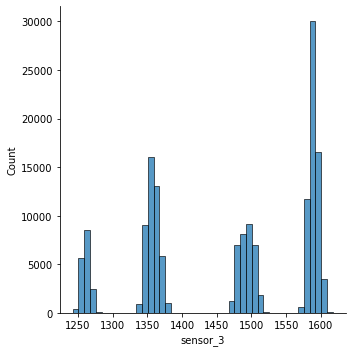

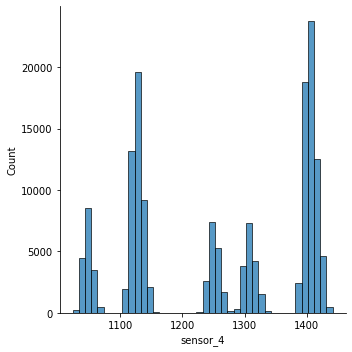

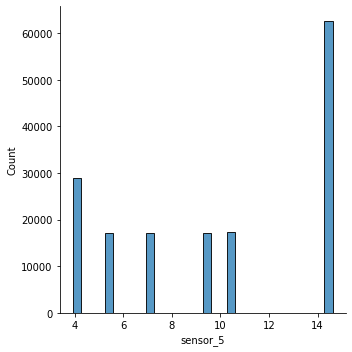

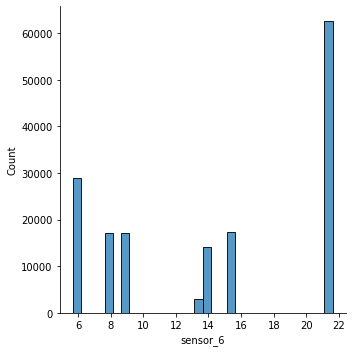

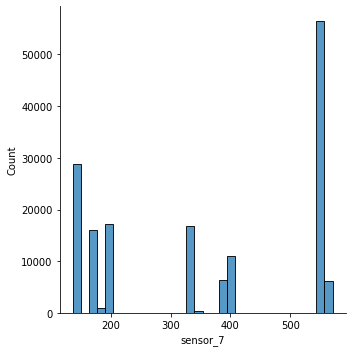

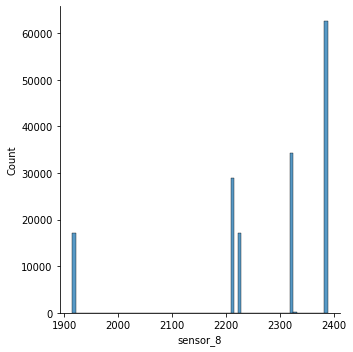

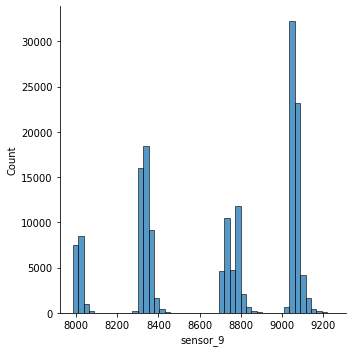

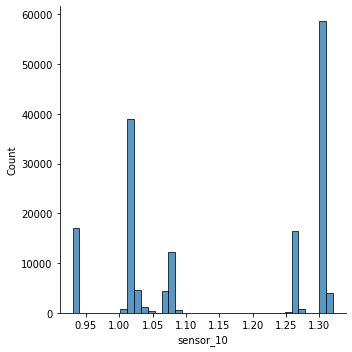

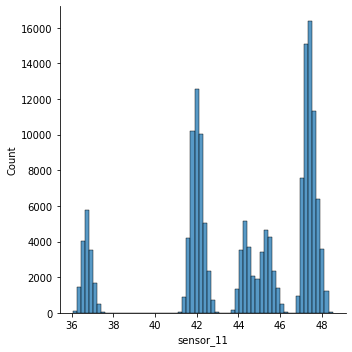

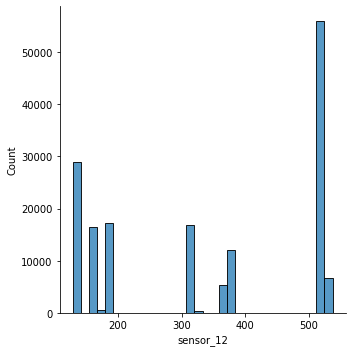

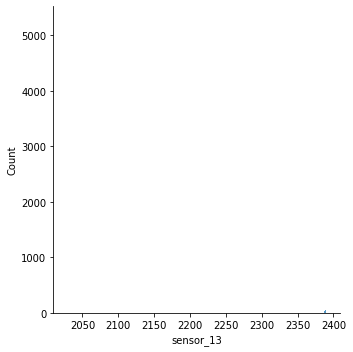

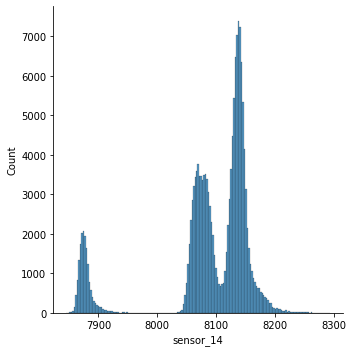

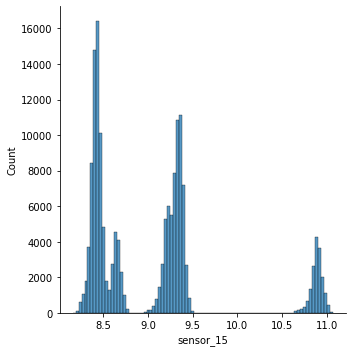

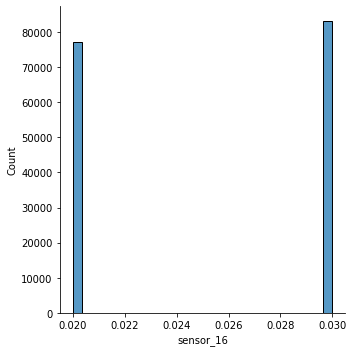

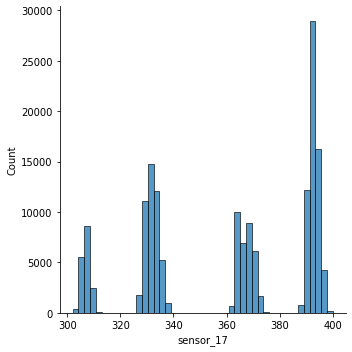

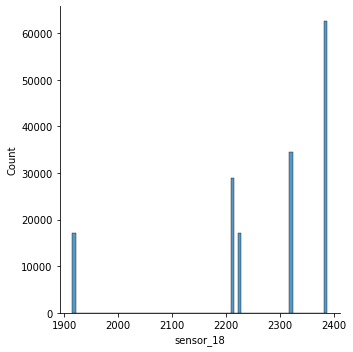

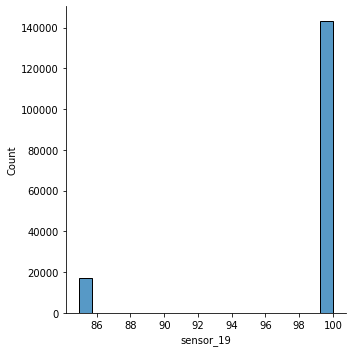

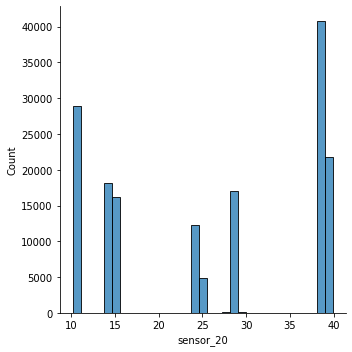

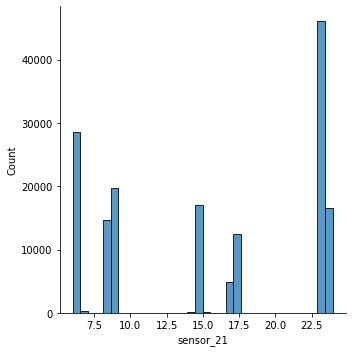

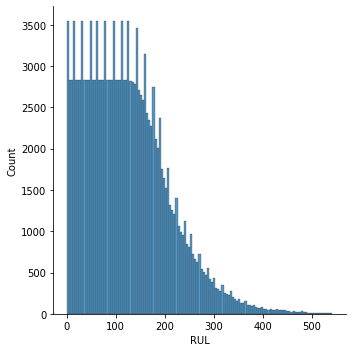

In [13]:
for col in train_df.columns:
  sns.displot(train_df[col])
  plt.show()

In [14]:
corrs

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
engine_no,1.000000,-0.005594,-0.010641,-0.010920,0.002628,0.010927,0.010515,0.010299,0.010330,0.011094,...,0.002609,0.006300,-0.009554,0.009783,0.010092,0.007483,0.002628,0.011401,0.011428,-0.005594
time_in_cycles,-0.005594,1.000000,-0.009588,-0.009960,0.000687,0.009526,0.012651,0.029766,0.036380,0.010034,...,0.001481,0.098462,-0.017034,0.043034,0.029852,0.005334,0.000687,0.010540,0.010593,-0.580971
op_setting_1,-0.010641,-0.009588,1.000000,0.967487,-0.163079,-0.979797,-0.925472,-0.877521,-0.909480,-0.991539,...,-0.163065,-0.459088,0.642981,-0.901542,-0.879403,-0.619531,-0.163079,-0.977664,-0.977674,-0.010300
op_setting_2,-0.010920,-0.009960,0.967487,1.000000,-0.197923,-0.939207,-0.898218,-0.867189,-0.912110,-0.965691,...,-0.197861,-0.527713,0.686817,-0.932897,-0.869323,-0.623632,-0.197923,-0.959658,-0.959656,-0.011275
op_setting_3,0.002628,0.000687,-0.163079,-0.197923,1.000000,0.264989,0.493244,0.601374,0.539436,0.230742,...,0.999998,0.904365,-0.843670,0.359027,0.598086,0.870889,1.000000,0.344868,0.344814,0.006096
sensor_1,0.010927,0.009526,-0.979797,-0.939207,0.264989,1.000000,0.969407,0.926589,0.943456,0.992550,...,0.264958,0.523178,-0.698151,0.873423,0.928151,0.704665,0.264989,0.987856,0.987864,0.010684
sensor_2,0.010515,0.012651,-0.925472,-0.898218,0.493244,0.969407,1.000000,0.989141,0.988864,0.954472,...,0.493222,0.702645,-0.844254,0.879724,0.989728,0.857009,0.493244,0.979178,0.979172,0.004582
sensor_3,0.010299,0.029766,-0.877521,-0.867189,0.601374,0.926589,0.989141,1.000000,0.993401,0.911783,...,0.601383,0.792588,-0.907534,0.878761,0.998944,0.914698,0.601374,0.952101,0.952087,-0.020455
sensor_4,0.010330,0.036380,-0.909480,-0.912110,0.539436,0.943456,0.988864,0.993401,1.000000,0.936864,...,0.539443,0.764897,-0.886103,0.912335,0.993885,0.877577,0.539436,0.969753,0.969742,-0.032047
sensor_5,0.011094,0.010034,-0.991539,-0.965691,0.230742,0.992550,0.954472,0.911783,0.936864,1.000000,...,0.230709,0.511161,-0.689424,0.892455,0.913622,0.675427,0.230742,0.992562,0.992570,0.010733


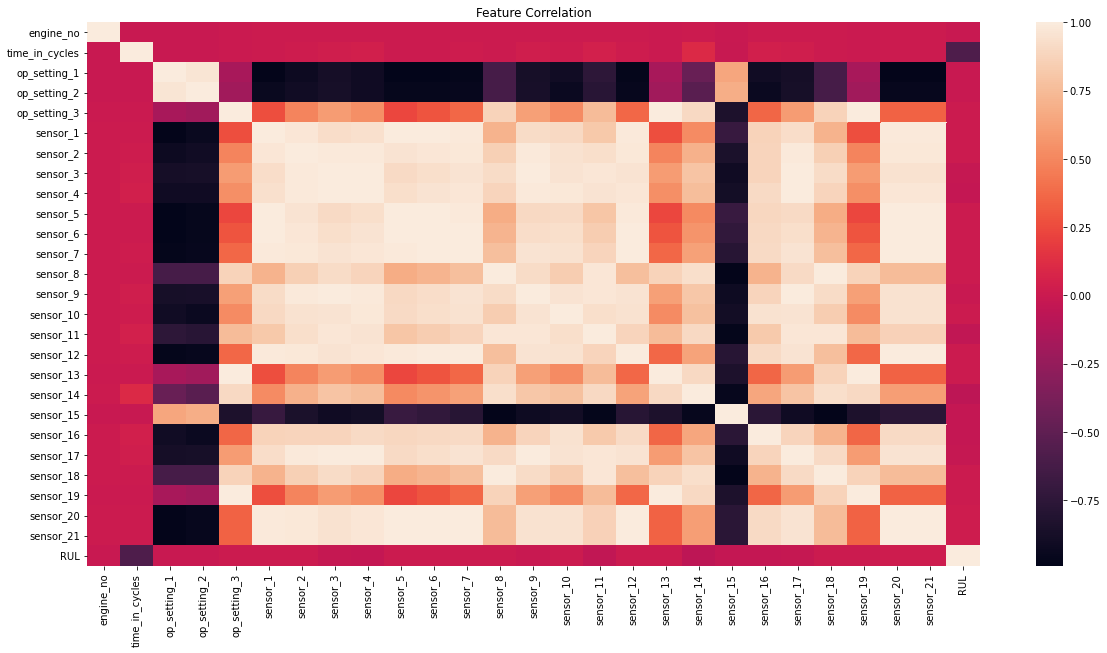

In [15]:
plt.figure(figsize = (20, 10))
sns.heatmap(corrs)
plt.title('Feature Correlation')
plt.show()

In [16]:
train_df.groupby('RUL').mean().sort_values('RUL', ascending = False)

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
RUL,,,,,,,,,,,,,,,,,,,,,
542,439.0,1.000000,10.001300,0.250000,100.000000,489.050000,604.350000,1490.150000,1295.630000,10.520000,...,372.740000,2388.060000,8135.520000,8.540900,0.030000,367.000000,2319.000000,100.000000,28.840000,17.293600
541,439.0,2.000000,35.007500,0.841200,100.000000,449.440000,555.180000,1363.100000,1128.310000,5.480000,...,184.510000,2388.100000,8072.250000,9.276600,0.020000,333.000000,2223.000000,100.000000,14.830000,8.879400
540,439.0,3.000000,25.007200,0.620000,60.000000,462.540000,536.250000,1265.350000,1038.790000,7.050000,...,164.800000,2028.300000,7874.960000,10.820200,0.020000,307.000000,1915.000000,84.930000,14.280000,8.533100
539,439.0,4.000000,34.998500,0.840000,100.000000,449.440000,555.720000,1357.940000,1119.550000,5.480000,...,183.790000,2388.050000,8071.290000,9.247400,0.020000,331.000000,2223.000000,100.000000,15.030000,8.960300
538,439.0,5.000000,9.999300,0.250000,100.000000,489.050000,604.590000,1497.570000,1301.510000,10.520000,...,373.170000,2388.070000,8131.490000,8.602900,0.030000,368.000000,2319.000000,100.000000,28.740000,17.308100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,354.0,222.176305,16.792000,0.400741,95.317348,486.381636,598.524231,1478.668279,1279.637151,9.993992,...,342.281340,2346.229915,8108.496516,9.100303,0.026037,363.713681,2271.581100,98.235811,26.034880,15.622149
3,354.0,223.176305,16.411052,0.397508,95.035261,486.982412,599.015882,1479.563977,1281.439379,10.041354,...,343.410254,2343.709647,8108.038251,9.112012,0.026319,363.994358,2270.698166,98.129535,26.126150,15.678738
2,354.0,224.176305,16.552148,0.408849,94.866008,486.916460,598.836657,1478.584570,1278.685078,10.040395,...,342.570169,2342.196135,8105.582736,9.132431,0.026220,363.682652,2269.088858,98.065769,26.081425,15.650929


In [17]:
rul_grouped = train_df.groupby('RUL').mean().sort_values('RUL', ascending = False)

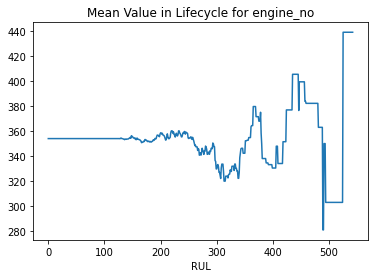

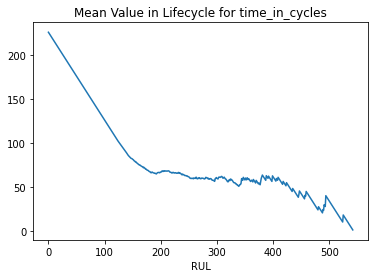

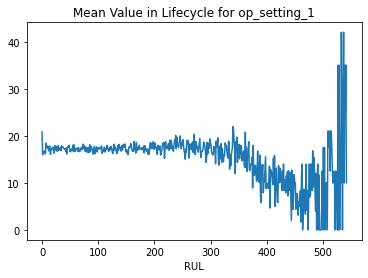

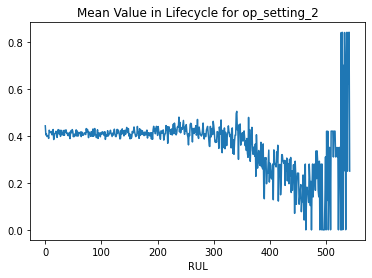

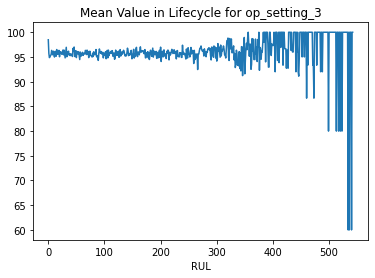

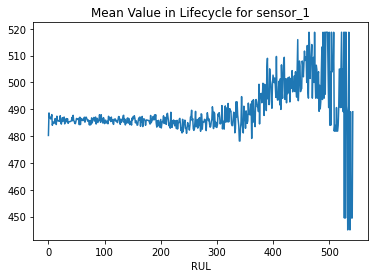

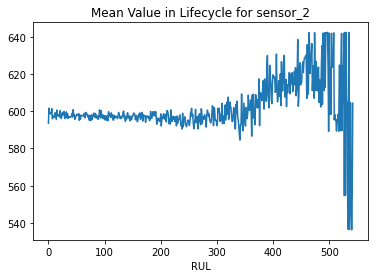

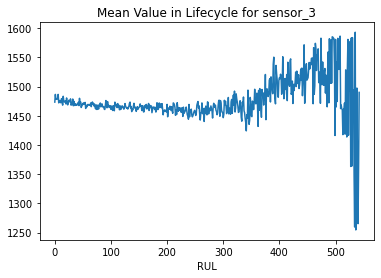

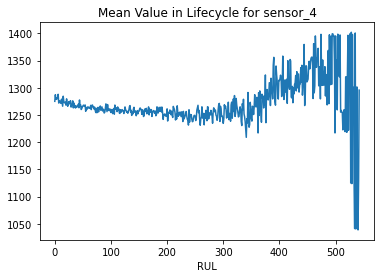

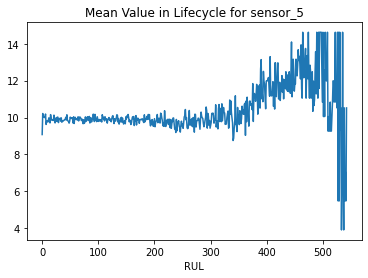

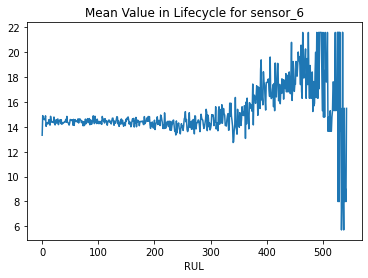

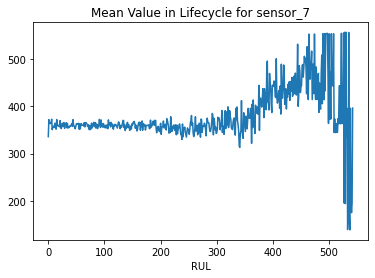

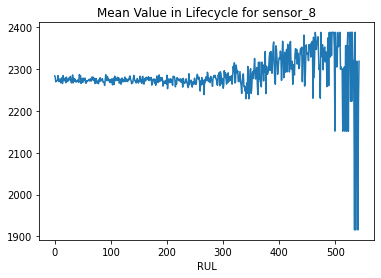

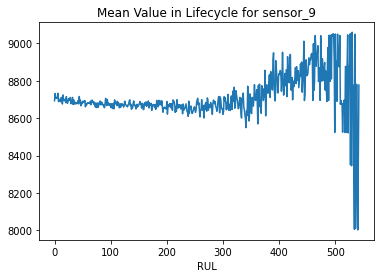

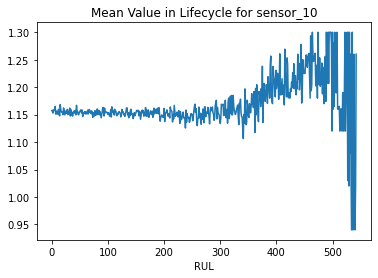

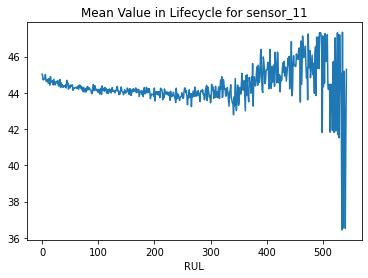

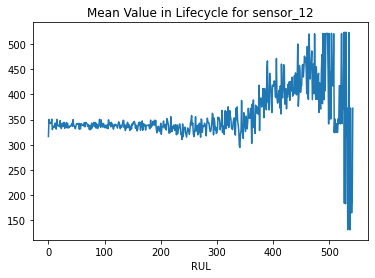

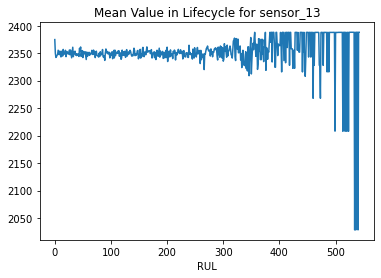

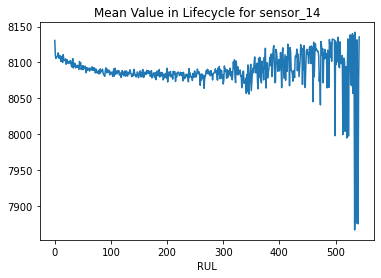

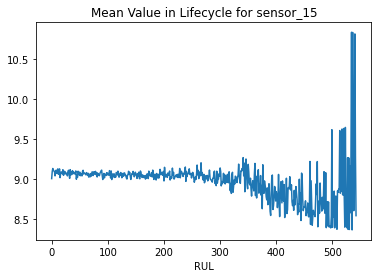

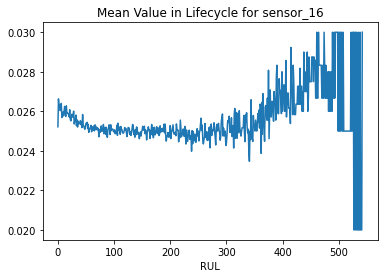

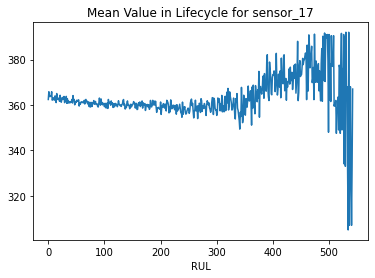

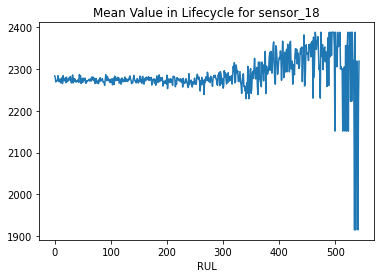

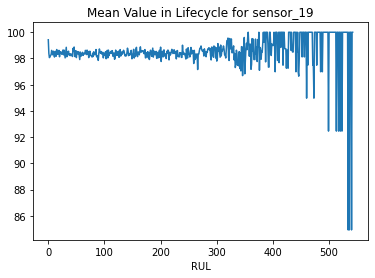

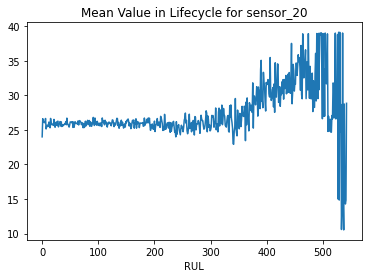

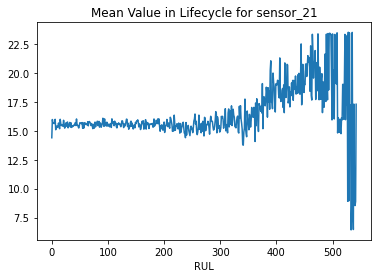

In [18]:
for col in rul_grouped.columns:
  train_df.groupby('RUL').mean().sort_values('RUL', ascending = False)[col].plot(title = 'Mean Value in Lifecycle for ' + col)
  plt.show()

Would be good to see how readings change across lifecycle depending on engine 

In [43]:
sample = train_df[(train_df.engine_no == 3) | (train_df.engine_no == 9) | (train_df.engine_no == 23)]

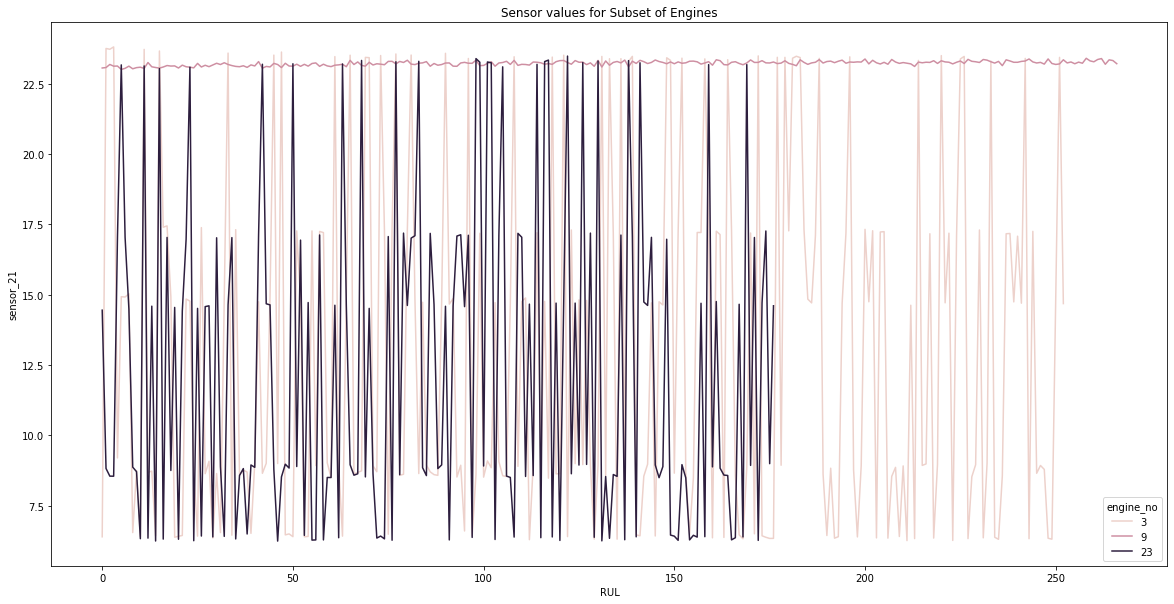

In [49]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = 'RUL', y = 'sensor_21', data = sample, hue = 'engine_no')
plt.title('Sensor values for Subset of Engines')
plt.show()

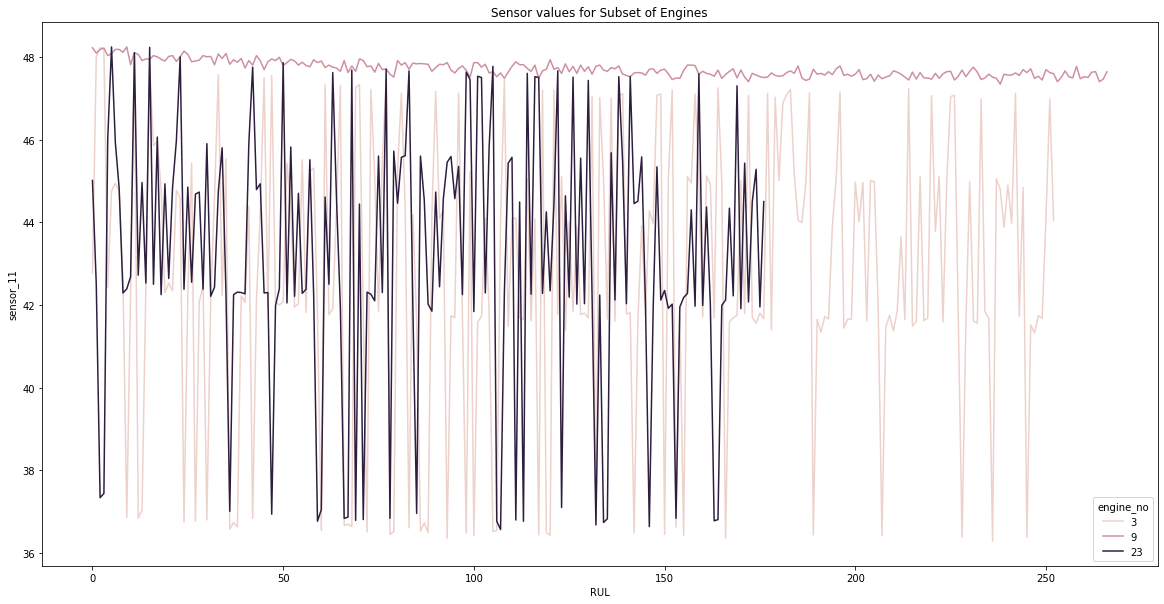

In [128]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = 'RUL', y = 'sensor_11', data = sample, hue = 'engine_no')
plt.title('Sensor values for Subset of Engines')
plt.show()

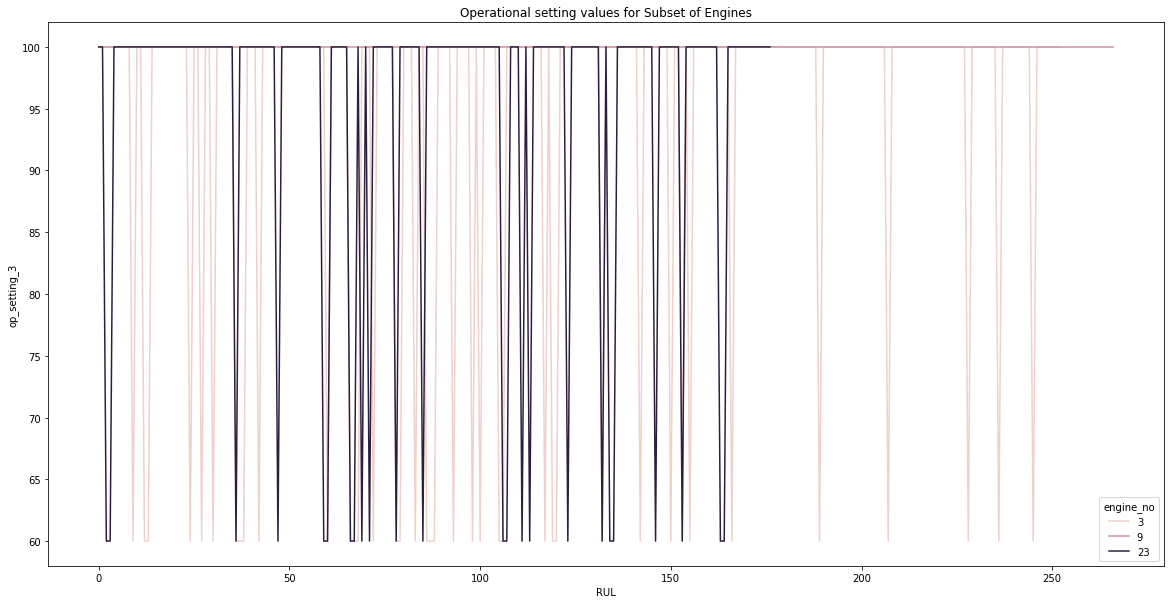

In [50]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'RUL', y = 'op_setting_3', data = sample, hue = 'engine_no')
plt.title('Operational setting values for Subset of Engines')
plt.show()

## Regression

This problem can be represented as a regression one because the 'RUL" can be modelled as a continuous variable, whereby the engine fails when the predicted value is close to 0. Different regression models require different assumptions, therefore each model will have different sets of feature engineering.

The following regression models will not directly aim to predict whether the engine has failed or not, as their intended purpose is to obtain a close match in the relationship between the features and the target variable.

### Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression

Start by creating a basuc Linear Regression Model using all features and basic feature engineering (expected to score badly because of high multi-colinearity between features and large number of features).

Engine number is categorical variable, due to high number of categories it will not be used for now.

In [52]:
train_df.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,...,2028.38,7875.47,10.8850,0.02,306,1915,84.93,14.35,8.4712,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,...,2388.20,8073.12,9.2527,0.02,334,2223,100.00,14.88,8.9928,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,...,2028.40,7884.88,10.9054,0.02,307,1915,84.93,14.21,8.5107,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,...,2388.13,8093.08,9.3434,0.02,331,2212,100.00,10.63,6.4578,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,...,2388.19,8078.18,9.3287,0.02,334,2223,100.00,14.95,9.0279,335


In [53]:
X, y = train_df.iloc[:, 1:-1], train_df.iloc[:, -1]

split into training and testing

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

scale data

In [55]:
sc = StandardScaler()

In [56]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [57]:
lm_model = LinearRegression() # instantiate

In [58]:
lm_model.fit(X_train_scaled, y_train) # fit data

LinearRegression()

In [59]:
y_hat = lm_model.predict(X_test_scaled) # predict

Assess predictions

In [60]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
mae = mean_absolute_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
print('rmse: ', rmse, '  mae: ', mae, '  r2: ', r2)

rmse:  51.88459564878568   mae:  38.970109005193784   r2:  0.6173301159714404


As expcted scores are low, due to little feature engineering/selection.

#### PCA

In order to reduce mulitcolinearity between variables, whilst maintaining the highest level of variance in the dataset, pca can be used.

In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=10)

In [63]:
X, y = train_df.iloc[:, 1:-1], train_df.iloc[:, -1]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [65]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [66]:
pca_df_train = pca.fit_transform(X_train_scaled)

In [67]:
pca_df_test = pca.transform(X_test_scaled)

In [68]:
pca.explained_variance_

array([1.96932955e+01, 3.88434397e+00, 1.01012784e+00, 2.83474484e-01,
       6.15835507e-02, 2.87782586e-02, 1.66164865e-02, 1.10742304e-02,
       5.71136250e-03, 1.84486014e-03])

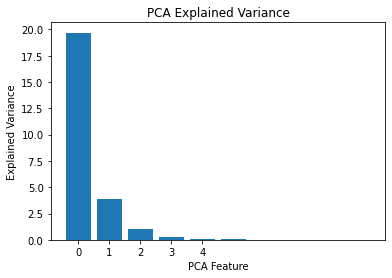

In [69]:
plt.bar(range(len(pca.explained_variance_)), pca.explained_variance_)
plt.title('PCA Explained Variance')
plt.xticks(range(0, 5))
plt.xlabel('PCA Feature')
plt.ylabel('Explained Variance')
plt.show()

Try new Linear Regression Model using PCA dataset

In [ ]:
lm_model_pca = LinearRegression()

In [ ]:
lm_model_pca.fit(pca_df_train, y_train) # fit to pca data

In [ ]:
y_hat = lm_model_pca.predict(pca_df_test) # Make predictions

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
mae = mean_absolute_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
print('rmse: ', rmse, '  mae: ', mae, '  r2: ', r2)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X, y = train_df.iloc[:, 1:-1], train_df.iloc[:, -1]

split into train and test

In [ ]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
rf_regressor = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 7,
    max_samples = 0.3, # only use 30% of samples each tree to combat multicolinearity & overfitting
    n_jobs = -1,
    
)

In [ ]:
rf_regressor.fit(X_train_scaled, y_train)

In [ ]:
y_hat = rf_regressor.predict(X_test_scaled) # predict

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
mae = mean_absolute_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
print('rmse: ', rmse, '  mae: ', mae, '  r2: ', r2)

### XGBoost

Gradient boosting ensemble method 

In [126]:
import xgboost as xgb

In [ ]:
X, y = train_df.iloc[:, 1:-1], train_df.iloc[:, -1]

In [ ]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Make initial pass at xgb model with no hyperparameter tuning

In [ ]:
xgb_model = xgb.XGBRegressor(n_jobs = -1) # Instantiate regressor

In [ ]:
xgb_model.fit(X_train_scaled, y_train)

In [ ]:
xgb_preds = xgb_model.predict(X_test_scaled) # make predictions

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
mae = mean_absolute_error(y_test,xgb_preds)
r2 = r2_score(y_test, xgb_preds)
print('rmse: ', rmse, '  mae: ', mae, '  r2: ', r2)

An ok first pass, with improved performance over previous models.

Now tune hyperparameters

In [ ]:
gbm_param_grid = {
    'learning_rate': [0.001, 0.01, 0.1], # learn rate for gradient descent
    'n_estimators': [100, 200, 400], # number of trees
    'subsample': [0.3, 0.5, 0.9], # fraction of samples to use
    'max_depth': [3, 5, 7], # max depth of tree
    'colsample_bytree': [0.5, 0.7, 0.9] # fraction of features to use
}

In [ ]:
grid_search = RandomizedSearchCV(
    estimator = xgb_model, 
    param_distributions= gbm_param_grid, 
    scoring = 'neg_mean_squared_error', 
    cv = 4, 
    n_iter=25, # search 25 combinations
    n_jobs = -1)


Want to punish outliers so use `neg_mean_squared_error` as scoring

In [ ]:
grid_search.fit(X_train_scaled, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
xgb_estimator = grid_search.best_estimator_

In [ ]:
xgb_preds = xgb_estimator.predict(X_test_scaled)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
mae = mean_absolute_error(y_test,xgb_preds)
r2 = r2_score(y_test, xgb_preds)
print('rmse: ', rmse, '  mae: ', mae, '  r2: ', r2)

Slight improvement in metrics achieved after hyperparameter tuning

### Deep Learning (Tensorflow)

Model will be of form multi-layer-perceptron (MLP)

Import libraries from tensorflow

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Define function for building ANN

In [ ]:
def build_ann_model(learn_rate=0.01, neurons = 32, n_layers = 2):
  model = Sequential()
  model.add(InputLayer(input_shape = (X_train_scaled.shape[1], )))
  for i in range(n_layers):
    model.add(Dense(neurons, activation='relu'))
  model.add(Dense(1))
  my_opt = Adam(learning_rate=learn_rate)
  model.compile(loss='mean_squared_error', metrics=['mae'], optimizer=my_opt)

  return model

In [ ]:
earlystop_callback = EarlyStopping(
    monitor='mae', 
    min_delta=0.001, 
    patience=5) # early stopping callback to prevent overfitting

Build and fit first model without hyperparameter tuning

In [ ]:
ann_model = build_ann_model(learn_rate = 0.001, n_layers = 2, neurons = 32)

Select & Scale data, use all features for now.

In [ ]:
X, y = train_df.iloc[:, 1:-1], train_df.iloc[:, -1]

In [ ]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
ann_model.fit(
    X_train_scaled, 
    y_train,
    epochs = 50, 
    batch_size=200,  
    callbacks = [earlystop_callback], 
    verbose=1, 
    validation_split=0.1
    )

In [ ]:
y_hat = ann_model.predict(X_test_scaled)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
mae = mean_absolute_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)
print('rmse: ', rmse, '  mae: ', mae, '  r2: ', r2)

Now tune hyperparameters

In [ ]:
def randomised_search(build_fn, X, y):
  param_grid = {
      'batch_size': [50, 75, 100, 150, 200, 400],
      'epochs': [20, 50, 100, 200],
      'learn_rate': [0.001, 0.01, 0.05],
      'neurons': [8, 16, 32, 48, 64],
      'n_layers': [1, 2, 3]
  }
  model = KerasRegressor(build_fn = build_fn)
  grid = RandomizedSearchCV(
    estimator = model,
    param_distributions = param_grid,
    n_jobs = 2,
    n_iter = 25
  )
  grid_result = grid.fit(X, y, verbose = 0)
  
  return grid_result

In [ ]:
grid_result = randomised_search(build_ann_model, X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print(grid_result.best_params_)
print(grid_result.best_score_)
print(grid_result.scorer_)

Build and fit according to result of random grid search

## Classification

This will involve creating a binary classifiation, whereby the engine has failed ('RUL' == 1) or it hasnt ('RUL' > 0). A new column will be created in the training dataset for this.

Feature engineer classification column

In [86]:
df_train_clf = train_df.copy() # make deep copy of train df

In [87]:
df_train_clf['Failed'] = df_train_clf['RUL'].apply(lambda x: 1 if x == 0 else 0) # binary classifcation according to value of RUL

In [88]:
df_train_clf.drop('RUL', axis = 1, inplace = True) # no longer need RUL

In [83]:
df_train_clf.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,Failed
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,...,2028.38,7875.47,10.8850,0.02,306,1915,84.93,14.35,8.4712,0
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,...,2388.20,8073.12,9.2527,0.02,334,2223,100.00,14.88,8.9928,0
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,...,2028.40,7884.88,10.9054,0.02,307,1915,84.93,14.21,8.5107,0
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,...,2388.13,8093.08,9.3434,0.02,331,2212,100.00,10.63,6.4578,0
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,...,2388.19,8078.18,9.3287,0.02,334,2223,100.00,14.95,9.0279,0


In [84]:
df_train_clf['Failed'].value_counts()

0    159650
1       709
Name: Failed, dtype: int64

### Logistic Regression

Will first try to predict failure using standard Logistic regression with minimal feature engineering.

In [85]:
from sklearn.linear_model import LogisticRegression

In [89]:
X, y = df_train_clf.iloc[:, 1:-1], df_train_clf.iloc[:, -1] # features and label

split into train and test. Need to stratify based on label so that even ratio between classes is achieved.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y) # train and test

In [94]:
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [102]:
lr_model = LogisticRegression(
    solver = 'newton-cg' # better for slightly larger datasets
)

In [103]:
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(solver='newton-cg')

In [118]:
y_hat = lr_model.predict(X_test_scaled)

In [124]:
f1_sc = f1_score(y_test, y_hat)
acc_score = accuracy_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
print('f1 score: ', f1_sc, '  accuracy score: ', acc_score, '  recall score: ', recall)

f1 score:  0.009345794392523364   accuracy score:  0.995593248524154   recall score:  0.004694835680751174


### XGBoost

will start by using default values for hyperparameters and then prigressing onto tuning to enhance accuracy.

In [127]:
xgb_clf_model = xgb.XGBClassifier(n_jobs = -1)

In [129]:
xgb_clf_model.fit(X_train_scaled, y_train)

XGBClassifier(n_jobs=-1)

In [131]:
y_hat = xgb_clf_model.predict(X_test_scaled)

In [132]:
f1_sc = f1_score(y_test, y_hat)
acc_score = accuracy_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
print('f1 score: ', f1_sc, '  accuracy score: ', acc_score, '  recall score: ', recall)

f1 score:  0.15384615384615385   accuracy score:  0.9956556082148499   recall score:  0.0892018779342723


Now perform hyperparameter tuning

In [133]:
gbm_param_grid = {
    'learning_rate': [0.001, 0.01, 0.1], # learn rate for gradient descent
    'n_estimators': [100, 200, 400], # number of trees
    'subsample': [0.3, 0.5, 0.9], # fraction of samples to use
    'max_depth': [3, 5, 7], # max depth of tree
    'colsample_bytree': [0.5, 0.7, 0.9] # fraction of features to use
}

In [137]:
grid_search = RandomizedSearchCV(
    estimator = xgb_clf_model, 
    param_distributions= gbm_param_grid, 
    scoring = 'recall', 
    cv = 4, 
    n_iter=25, # search 25 combinations
    n_jobs = -1)


In [ ]:
grid_search.fit(X_train_scaled, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
xgb_clf_estimator = grid_search.best_estimator_

In [ ]:
xgb_preds = xgb_clf_estimator.predict(X_test_scaled)

In [ ]:
f1_sc = f1_score(y_test, y_hat)
acc_score = accuracy_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
print('f1 score: ', f1_sc, '  accuracy score: ', acc_score, '  recall score: ', recall)

### Deep Learning (Tensorflow)

Define DL classification build function

In [ ]:
def build_ann_clf_model(learn_rate=0.01, neurons = 32, n_layers = 2):
  model = Sequential()
  model.add(InputLayer(input_shape = (X_train_scaled.shape[1], )))
  for i in range(n_layers):
    model.add(Dense(neurons, activation='relu'))
  model.add(Dense(2, activation = 'softmax'))
  my_opt = Adam(learning_rate=learn_rate)
  model.compile(loss='sparse_categorical_crossentropy', metrics=['f1_score'], optimizer=my_opt)

  return model

In [ ]:
ann_clf = build_ann_clf_model(
  
)

In [ ]:
ann_clf.fit(X_train_scaled, y_train) # fit to data

In [ ]:
ann_clf_preds = ann_clf.predict(X_test_scaled)

In [ ]:
ann_clf_preds